# Assignment 2

Group L:

Natalia Aponte 01299891

Qiuyue Zhang 01378527

Benjamin Barros Gutierrez 01402212

Shuyu Zhou 01382817

# 1. Data Preparation

*Note: Code for variable construction is in the "Variable Construction.R" file.*

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns 
%matplotlib inline
from sklearn.linear_model import LinearRegression,LassoCV,ElasticNetCV
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint as sp_randint
import random
import re

In [3]:
# import data
change_spot_rate = pd.read_csv('ChangeInSpotRate.csv').add_prefix('spot_rate_')
interest_diferential = pd.read_csv('InterestDifferential.csv').add_prefix('interest_')
inflation_diferential = pd.read_csv('InflationDifferential.csv').add_prefix('inflation_')
ip_diferential = pd.read_csv('IPDifferential.csv').add_prefix('ip_')
ms_diferential = pd.read_csv('MSDifferential.csv').add_prefix('ms_')
# combine data set
data = pd.concat([change_spot_rate, interest_diferential,inflation_diferential,ip_diferential,ms_diferential], axis=1, join_axes=[change_spot_rate.index])
data = data[data.columns.drop(list(data.filter(regex='Date')))]

# 2. Prediction: expanding window
In this part we use expanding window method to calculate the **historical mean as benchmark**, and apply **lasso**, **elastic net** and **random forest** technique. We predict **all the currencies** for this part.

## Lasso, Elastic Net and Random Forest

In [1]:
currencies = ['AUD','CAD','CHF','EUR','GBP','JPY','NOK','NZD','SEK']
random.seed(12)
# create dataframe for predicting result
model_predictions = pd.DataFrame(columns=['currency','model','fold','month_number','prediction','true_value'])
#Main loop. Iterate ver each currency
for currency in currencies:
    
    data_copy = data.copy()
    
    #The target variable is selected depending on the current currency
    data_copy['y'] = data_copy['spot_rate_'+currency+'_CSR'].shift(-1)
    data_copy = data_copy[1:-1]

    n_folds = 5
    
    ### We select only predictors (X) related to the currency
    X, y = data_copy.drop(['y'],axis=1).select(lambda x: re.search(currency, x), axis=1),data_copy['y']       
    
    #Initialisate train/test using n folds timeseries split
    tscv_outer = TimeSeriesSplit(n_splits=n_folds)
    
    for k, (train_index, test_index) in enumerate(tscv_outer.split(X)):
        
        print('currency: '+ currency + ' fold: ' + str(k))   
        
        #generate train / test sets
        X_train, X_test, y_train, y_test = X.iloc[train_index],X.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
        
        original_data_index = (y_test.index+1).tolist()
        true_value = y_test.tolist()
        
        #expanding window
        ## There is no training fase so the predicted values are computed directly
        expanding_window_prediction = X['spot_rate_'+currency+'_CSR'].expanding(min_periods=1).mean().shift(1).iloc[test_index]     
        model_predictions.loc[len(model_predictions)] = [currency,'expanding_window',k,original_data_index,expanding_window_prediction.tolist(),true_value]
        
        # linear regression
        linear_regression_clf = LinearRegression()
        linear_regression_clf.fit(X_train,y_train)
        linear_regression_predictions = linear_regression_clf.predict(X_test)
        model_predictions.loc[len(model_predictions)] = [currency,'linear_regression',k,original_data_index,linear_regression_predictions,true_value]
        
        ### we generate another time series split for hyperparameter tunning
        
        inner_folds_size = 5
        lasso_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
        
        # lasso with time series split cv
        lasso_clf = LassoCV(max_iter=1000, cv = lasso_tscv_inner_generator)
        lasso_clf.fit(X_train,y_train)
        lasso_predictions = lasso_clf.predict(X_test)
        model_predictions.loc[len(model_predictions)] = [currency,'lasso',k,original_data_index,lasso_predictions,true_value]
     
       
        en_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
        # elastic net with time series split cv
        en_clf = ElasticNetCV(normalize=True,precompute=True,selection = 'random',max_iter=10000, cv = en_tscv_inner_generator)
        en_clf.fit(X_train,y_train)
        en_predictions = en_clf.predict(X_test)
        model_predictions.loc[len(model_predictions)] = [currency,'elastic_net',k,original_data_index,en_predictions,true_value]
        
        #Random Forest with time series split cv and randomized searh
        rf_clf = RandomForestRegressor(n_estimators=100)
    
        param_grid = {
                      "max_depth": sp_randint(2, 5),
                      "min_samples_leaf": sp_randint(10, 50)
                      }
        
        # run randomized search
        n_iter_search = 15
        
        #Generate time series splits for CV
        rf_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
        rf_cv = RandomizedSearchCV(rf_clf, param_distributions=param_grid,n_iter=n_iter_search, cv = rf_tscv_inner_generator)
        rf_cv.fit(X_train,y_train)        
        rf_predictions = rf_cv.predict(X_test)
        model_predictions.loc[len(model_predictions)] = [currency,'random_forest',k,original_data_index,rf_predictions,true_value]

## Cumulative SSE

In [120]:
# define necessary function
def cul_sse(true, historical): # calculating culmulative SSE
    cul_sse = []
    length = len(true)
    for i in range(0, length):
        y_true = true[0:i+1]
        y_his =  historical[0:i+1]
        sse = np.sum((y_his-y_true)**2)
        cul_sse.append(sse)
    return cul_sse
# Put predicting data into dataframe
def form_df(currency): 
    data_cur = model_predictions[model_predictions.currency==currency]
    model_list = data_cur.model[0:5].tolist()
    rmse_list=[]
    month_list=[]
    predict_list=[]
    ture_list=[]
    for i in model_list:
        data_cur2 = data_cur[data_cur.model==i]
        data_cur2 = data_cur2.reset_index()
        for j in range(len(data_cur2)):
            month_list.extend(data_cur2.month_number[j])
            predict_list.extend(data_cur2.prediction[j])
            ture_list.extend(data_cur2.true_value[j])
        rmse=cul_sse(np.array(ture_list), np.array(predict_list))
        rmse_list.append(rmse)
        month_list=[]
        predict_list=[]
        ture_list=[]
    dict_a = {}
    for i in range(5):
        dict_a[model_list[i]]=rmse_list[i]
    df_cur = pd.DataFrame(dict_a)
    df_final = df_cur.apply(lambda x: np.array(df_cur.expanding_window)-x).drop('expanding_window', axis=1).drop('linear_regression', axis=1)
    df_final.columns = ['Elastic Net', 'Lasso', 'Random Forest']
    return(df_final)

In [121]:
AUD_prediction = form_df('AUD')
CAD_prediction = form_df('CAD')
CHF_prediction = form_df('CHF')
EUR_prediction = form_df('EUR')
GBP_prediction = form_df('GBP')
JPY_prediction = form_df('JPY')
NOK_prediction = form_df('NOK')
NZD_prediction = form_df('NZD')
SEK_prediction = form_df('SEK')

## Visualization
### Compare ML technique on single currency

Text(0.5,1,'AUD prediction: expanding window')

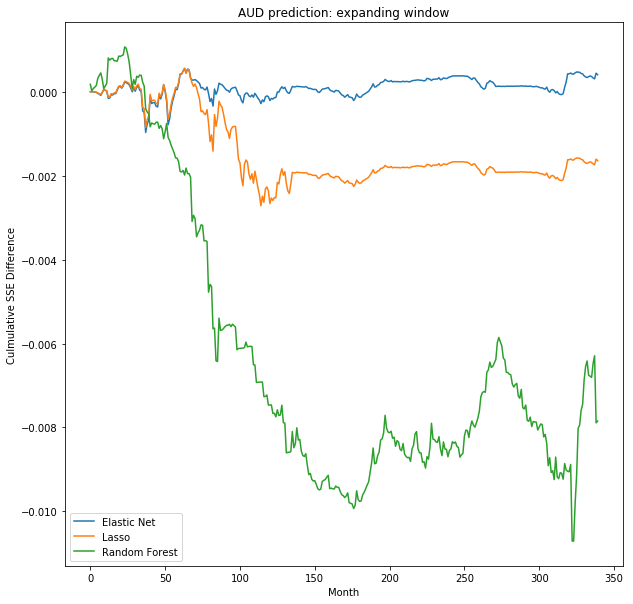

In [122]:
# AUD as an example
AUD_prediction.columns = ['Elastic Net', 'Lasso', 'Random Forest']
plt.rcParams['figure.figsize'] = (10,10)
AUD_prediction.iloc[:,:].plot()
plt.xlabel('Month') 
plt.ylabel('Culmulative SSE Difference') 
plt.title('AUD prediction: expanding window')

### Compare ML technique for all currencies

Text(0.5,1,'Compare various ML techinique')

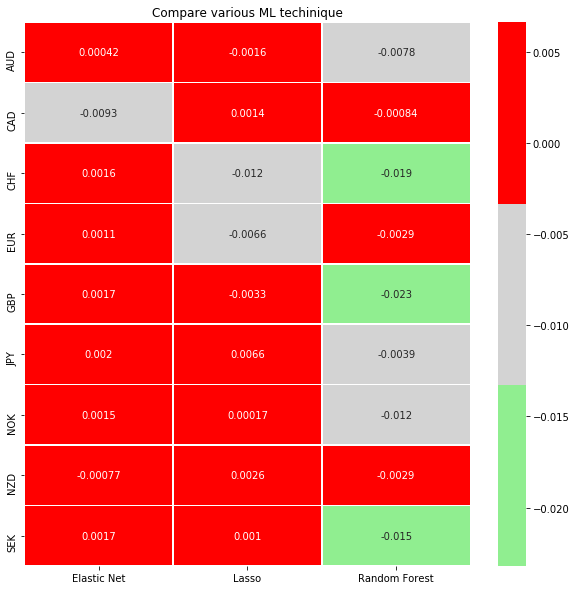

In [123]:
aud = AUD_prediction.iloc[-1,:]
cad = CAD_prediction.iloc[-1,:]
chf = CHF_prediction.iloc[-1,:]
eur = EUR_prediction.iloc[-1,:]
gbp = GBP_prediction.iloc[-1,:]
jpy = JPY_prediction.iloc[-1,:]
nok = NOK_prediction.iloc[-1,:]
nzd = NZD_prediction.iloc[-1,:]
sek = SEK_prediction.iloc[-1,:]
summary_table = pd.DataFrame([aud, cad, chf, eur, gbp, jpy, nok, nzd, sek], index=currencies)
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(summary_table,annot=True,linewidths=.5, cmap=ListedColormap(['lightgreen', 'lightgrey', 'red']))
plt.title('Compare various ML techinique')

# 3. Prediction: rolling window
In this part we use **rolling window** method. We first select the best window size for **historical mean as benchmark**, and then select the best rolling window size for every technique(**LASSO**, **elastic net** and **random forest**) and compare it to our benchmark. We only apply this method to predict **AUD**.

In [2]:
currencies = ['AUD']#,'CAD','CHF','EUR','GBP','JPY','NOK','NZD','SEK']
random.seed(12)

n_folds = 10
inner_folds_size = 3
window_sizes = [x**2 for x in range(9,17,1)]

# create dataframe for predicting result
model_predictions = pd.DataFrame(columns=['currency','model','fold','month_number','prediction','true_value','benchmark','windows_size'])
    

# For each windows size
for windows_size in window_sizes:

    #Main loop. Iterate ver each currency
    for currency in currencies:
        
        data_copy = data.copy()
        
        #The target variable is selected depending on the current currency
        data_copy['y'] = data_copy['spot_rate_'+currency+'_CSR'].shift(-1)
        data_copy = data_copy[1:-1]
    
        
        ### We select only predictors (X) related to the currency
        X, y = data_copy.drop(['y'],axis=1).select(lambda x: re.search(currency, x), axis=1),data_copy['y']       
        
        #Initialisate train/test using n folds timeseries split
        tscv_outer = TimeSeriesSplit(n_splits=n_folds)
        
        for k, (train_index, test_index) in enumerate(tscv_outer.split(X)):
            
            print('currency: '+ currency + ' fold: ' + str(k) + " window size: "+str(windows_size))   
            
            #generate train / test sets
            X_train, X_test, y_train, y_test = X.iloc[train_index][-windows_size:],X.iloc[test_index],y.iloc[train_index][-windows_size:],y.iloc[test_index]
            
            original_data_index = (y_test.index+1).tolist()
            true_value = y_test.tolist()
            
            #rolling window
            ## There is no training phase so the predicted values are computed directly
            rolling_window_prediction = X['spot_rate_'+currency+'_CSR'].rolling(min_periods=1, window=windows_size).mean().shift(1).iloc[test_index]
            model_predictions.loc[len(model_predictions)] = [currency,'rolling_window',k,original_data_index,rolling_window_prediction.tolist(),true_value,rolling_window_prediction.tolist(),windows_size]
            
            ### we generate another time series split for hyperparameter tunning
            
            inner_folds_size = 5
            lasso_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
            
            # lasso with time series split cv
            lasso_clf = LassoCV(max_iter=100, cv = lasso_tscv_inner_generator)
            lasso_clf.fit(X_train,y_train)
            lasso_predictions = lasso_clf.predict(X_test)
            model_predictions.loc[len(model_predictions)] = [currency,'lasso',k,original_data_index,lasso_predictions,true_value,rolling_window_prediction.tolist(),windows_size]
         
           
            en_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
            # elastic net with time series split cv
            en_clf = ElasticNetCV(normalize=True,precompute=True,selection = 'random',max_iter=1000, cv = en_tscv_inner_generator)
            en_clf.fit(X_train,y_train)
            en_predictions = en_clf.predict(X_test)
            model_predictions.loc[len(model_predictions)] = [currency,'elastic_net',k,original_data_index,en_predictions,true_value,rolling_window_prediction.tolist(),windows_size]
            
            #Random Forest with time series split cv and randomized searh
            rf_clf = RandomForestRegressor(n_estimators=50)
        
            param_grid = {
                          "max_depth": sp_randint(2, 5),
                          "min_samples_leaf": sp_randint(10, 50)
                          }
            
            # run randomized search
            n_iter_search = 10
            
            #Generate time series splits for CV
            rf_tscv_inner_generator = TimeSeriesSplit(n_splits=inner_folds_size).split(X_train)
            rf_cv = RandomizedSearchCV(rf_clf, param_distributions=param_grid,n_iter=n_iter_search, cv = rf_tscv_inner_generator)
            rf_cv.fit(X_train,y_train)        
            rf_predictions = rf_cv.predict(X_test)
            model_predictions.loc[len(model_predictions)] = [currency,'random_forest',k,original_data_index,rf_predictions,true_value,rolling_window_prediction.tolist(),windows_size]

In [173]:
model_predictions_unpivoted = model_predictions.groupby(['currency','model',"windows_size",'fold'])['true_value'].apply(lambda x: pd.DataFrame(x.values[0])).reset_index().rename(columns={0: 'true_value'}).drop(['level_4'],axis=1)
model_predictions_unpivoted['prediction'] =(model_predictions.groupby(['currency','model',"windows_size",'fold'])['prediction'].apply(lambda x: pd.DataFrame(x.values[0])).reset_index())[0]
model_predictions_unpivoted['benchmark'] =(model_predictions.groupby(['currency','model',"windows_size",'fold'])['benchmark'].apply(lambda x: pd.DataFrame(x.values[0])).reset_index())[0]    
model_predictions_unpivoted = model_predictions_unpivoted.assign( benchmark_se = lambda x: (x.benchmark - x.true_value)**2,model_se = lambda x: (x.prediction - x.true_value)**2)
model_predictions_unpivoted['delta_cummulative_sse'] = model_predictions_unpivoted.groupby(['currency','model',"windows_size"])['benchmark_se'].cumsum()-model_predictions_unpivoted.groupby(['currency','model',"windows_size"])['model_se'].cumsum()
model_predictions_unpivoted['cummulative_sse'] = model_predictions_unpivoted.groupby(['currency','model',"windows_size"])['model_se'].cumsum()
best_window = pd.DataFrame(columns=['model','best_window'])

In [174]:
count = -1
for num,model in enumerate(['elastic_net','random_forest','lasso','rolling_window']): 
    count=count+1
    model_windows_results = model_predictions_unpivoted.groupby(['currency','model',"windows_size"]).last().cummulative_sse.reset_index()
    model_windows_results = pd.DataFrame(model_windows_results.loc[(model_windows_results.currency=='AUD') & (model_windows_results.model==model),['cummulative_sse']].cummulative_sse)
    model_windows_results['window_size']=window_sizes
    #plt.plot(model_windows_results.window_size,model_windows_results.cummulative_sse)
    #plt.show()
    best_window.loc[count]=[model,model_windows_results.loc[model_windows_results.cummulative_sse.idxmin()].window_size]

## Visualization

Text(0.5,1,'AUD prediction: rolling window')

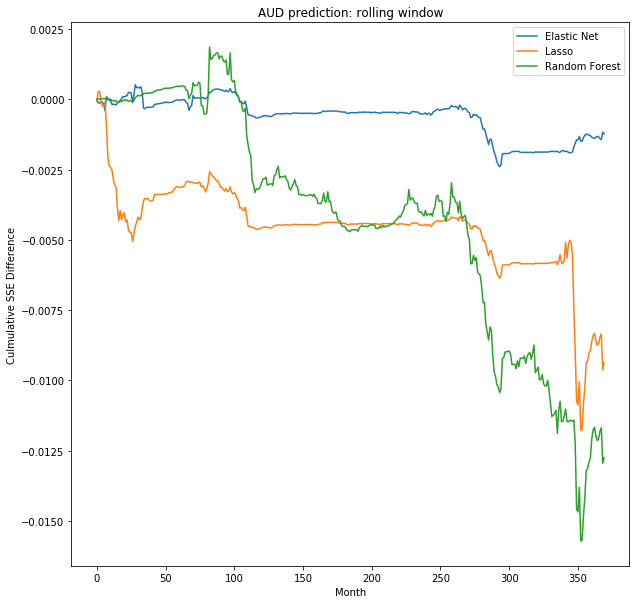

In [176]:
best_dict = {}
for i in best_window.model.tolist():
    for j in best_window.best_window.tolist():
        a = np.array(model_predictions_unpivoted.loc[(model_predictions_unpivoted.model==i) & (model_predictions_unpivoted.windows_size==j)].delta_cummulative_sse)
        best_dict[i] = a
best_AUD = pd.DataFrame(best_dict).drop('rolling_window', axis=1)
best_AUD.columns = ['Elastic Net', 'Lasso', 'Random Forest']
plt.rcParams['figure.figsize'] = (10,10)
best_AUD.iloc[:,:].plot()
plt.xlabel('Month') 
plt.ylabel('Culmulative SSE Difference') 
plt.title('AUD prediction: rolling window')